<h1 align="center"> Image Captioning </h1>

In this notebook you will teach a network to do image captioning
![img](https://cdn-images-1.medium.com/max/716/1*vzFwXFJOrg6WRGNsYYT6qg.png)
_image [source](https://towardsdatascience.com/image-captioning-in-deep-learning-9cd23fb4d8d2)_



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [0]:
# Please either download data from https://yadi.sk/d/b4nxAwIE73TVcp5 or generate it manually with preprocess_data.

**For Google Colab**

In [1]:
!pip install pydrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
download = drive.CreateFile({'id': '1SbzdA9xEJoabQbRREvenzuUehpQuh841'})
download.GetContentFile('handout.tar.gz')
!tar -xvzf handout.tar.gz
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.4.1-cp36-cp36m-linux_x86_64.whl torchvision
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/week07_seq2seq/beheaded_inception3.py -O beheaded_inception3.py

    100% |████████████████████████████████| 993kB 19.8MB/s 
  Running setup.py bdist_wheel for pydrive ... - \ done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive
data/
data/captions_tokenized.json
data/image_codes.npy
    100% |████████████████████████████████| 483.0MB 59.7MB/s 
tcmalloc: large alloc 1073750016 bytes == 0x55f88000 @  0x7f3bb14d02a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 61kB 1.2MB/s 
    100% |████████████████████████████████| 2.0MB 6.0MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
--2018-11-13 10:56:35--  https://raw.githubusercont

### Data preprocessing

In [1]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 186 ms, sys: 699 ms, total: 885 ms
Wall time: 888 ms


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [3]:
img_codes.shape

(118287, 2048)

In [4]:
captions[0]

['people shopping in an open market for vegetables .',
 'an open market full of people and piles of vegetables .',
 'people are shopping at an open air produce market .',
 'large piles of carrots and potatoes at a crowded outdoor market .',
 'people shop for vegetables like carrots and potatoes at an open air market .']

In [3]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [0]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [6]:
captions[0][0]

['#START#',
 'people',
 'shopping',
 'in',
 'an',
 'open',
 'market',
 'for',
 'vegetables',
 '.',
 '#END#']

In [0]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

#Compute word frequencies for each word in captions. See code above for data structure
for caption_version in captions:
  for caption in caption_version:
    for word in caption:
      word_counts[word] += 1

In [0]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [0]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [10]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [0]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size)
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size,lstm_units,batch_first=True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units,n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg
        

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, _ = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        
        return logits        

In [0]:
network = CaptionNet(n_tokens)

In [9]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [0]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float tensor
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    mask = (captions_ix_next != pad_ix).float()
    txlogy = torch.gather(F.log_softmax(logits_for_next, dim=-1), -1, captions_ix_next.unsqueeze(-1)).squeeze(-1)
    loss = - torch.sum( txlogy*mask )/logits_for_next.shape[0]/logits_for_next.shape[1]
    
    return loss

In [0]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [0]:
opt = torch.optim.Adam(network.parameters(), lr = 0.001)

# Training

* First implement the batch generator
* Than train the network as usual

In [0]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [0]:
from random import choice

def generate_batch(img_codes, captions, batch_size, device, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32,device=device), torch.tensor(batch_captions_ix, dtype=torch.int64, device=device)
    

In [104]:
generate_batch(img_codes,captions,3)

(tensor([[0.1409, 0.0127, 0.2348,  ..., 0.8703, 0.2062, 0.2370],
         [0.3708, 0.4034, 0.3607,  ..., 0.7731, 0.8583, 0.6602],
         [0.4696, 0.6651, 0.6895,  ..., 0.3055, 0.4433, 1.0961]]),
 tensor([[   1,   24,  439,   14, 6102,  296,  889,  183,   24,  184,   12,    2,
             3,    3],
         [   1,   24,  500, 1271,   35,  500,  502,  193,  117,  127,  413,   12,
             2,    3],
         [   1,   24,  291,  300,   58,  437,   15,   24, 1554,  123, 3501,  442,
            12,    2]]))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [0]:
batch_size = 50  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch
device = torch.device("cuda")

In [0]:
from tqdm import tqdm


def train(model, opt,n_epochs, n_batches_per_epoch, n_validation_batches, device):
  for epoch in range(n_epochs):

      train_loss=0
      network.train(True)
      for _ in tqdm(range(n_batches_per_epoch)):

          loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size,device))


          # clear old gradients; do a backward pass to get new gradients; then train with opt
          network.zero_grad()
          loss_t.backward()
          opt.step()

          train_loss += loss_t.detach().cpu().numpy()

      train_loss /= n_batches_per_epoch

      val_loss=0
      network.train(False)
      for _ in range(n_validation_batches):
          loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size, device))
          val_loss += loss_t.detach().cpu().numpy()
      val_loss /= n_validation_batches

      print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

  print("Finished!")

### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [0]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

In [0]:
def generate_caption(image, caption_prefix = ("#START#",), 
                     t=1, sample=True, max_len=100 ,device=torch.device("cuda")):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32, device=device)
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64, device=device)
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).detach().cpu().numpy()
        
        
        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break
            
    return caption_prefix

In [0]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

### Training

In [19]:
inception.to(device)
network.to(device)

CaptionNet(
  (cnn_to_h0): Linear(in_features=2048, out_features=256, bias=True)
  (cnn_to_c0): Linear(in_features=2048, out_features=256, bias=True)
  (emb): Embedding(10403, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (logits): Linear(in_features=256, out_features=10403, bias=True)
)

In [20]:
train(network, opt,n_epochs, n_batches_per_epoch, n_validation_batches, device)

 10%|█         | 5/50 [00:00<00:01, 41.60it/s]


Epoch: 0, train loss: 3.6779465675354004, val loss: 2.75578351020813


 10%|█         | 5/50 [00:00<00:01, 43.31it/s]


Epoch: 1, train loss: 2.8526126027107237, val loss: 2.804989385604858


  8%|▊         | 4/50 [00:00<00:01, 37.94it/s]


Epoch: 2, train loss: 2.718043098449707, val loss: 2.724426507949829


  8%|▊         | 4/50 [00:00<00:01, 38.92it/s]


Epoch: 3, train loss: 2.5067449855804442, val loss: 2.122057056427002


  8%|▊         | 4/50 [00:00<00:01, 38.44it/s]


Epoch: 4, train loss: 2.437221636772156, val loss: 2.5659039497375487


 10%|█         | 5/50 [00:00<00:01, 41.78it/s]


Epoch: 5, train loss: 2.3504305624961854, val loss: 2.586208963394165


 10%|█         | 5/50 [00:00<00:01, 42.81it/s]


Epoch: 6, train loss: 2.3574863028526307, val loss: 2.396480751037598


 10%|█         | 5/50 [00:00<00:01, 43.40it/s]


Epoch: 7, train loss: 2.2812057614326475, val loss: 2.38498272895813


 10%|█         | 5/50 [00:00<00:01, 43.06it/s]


Epoch: 8, train loss: 2.2882412767410276, val loss: 1.8493096828460693


  8%|▊         | 4/50 [00:00<00:01, 34.72it/s]


Epoch: 9, train loss: 2.166458692550659, val loss: 2.175742030143738


  8%|▊         | 4/50 [00:00<00:01, 39.41it/s]


Epoch: 10, train loss: 2.0685439252853395, val loss: 1.9189405679702758


 10%|█         | 5/50 [00:00<00:01, 42.06it/s]


Epoch: 11, train loss: 2.1737344336509703, val loss: 2.0131542921066283


  8%|▊         | 4/50 [00:00<00:01, 34.99it/s]


Epoch: 12, train loss: 2.119558835029602, val loss: 1.9928177356719972


  8%|▊         | 4/50 [00:00<00:01, 39.29it/s]


Epoch: 13, train loss: 2.057028670310974, val loss: 1.8717777967453002


  8%|▊         | 4/50 [00:00<00:01, 39.96it/s]


Epoch: 14, train loss: 2.058580412864685, val loss: 1.8781186103820802


 10%|█         | 5/50 [00:00<00:01, 40.68it/s]


Epoch: 15, train loss: 2.1096426320075987, val loss: 1.938900923728943


 10%|█         | 5/50 [00:00<00:01, 41.41it/s]


Epoch: 16, train loss: 1.995803964138031, val loss: 2.0812210559844972


  8%|▊         | 4/50 [00:00<00:01, 39.82it/s]


Epoch: 17, train loss: 2.080233427286148, val loss: 2.0715860605239866


  8%|▊         | 4/50 [00:00<00:01, 32.34it/s]


Epoch: 18, train loss: 1.930318021774292, val loss: 1.8532799243927003


  8%|▊         | 4/50 [00:00<00:01, 34.53it/s]


Epoch: 19, train loss: 1.9115548133850098, val loss: 1.8776405811309815


  8%|▊         | 4/50 [00:00<00:01, 39.02it/s]


Epoch: 20, train loss: 1.863170430660248, val loss: 1.670262336730957


  8%|▊         | 4/50 [00:00<00:01, 38.83it/s]


Epoch: 21, train loss: 1.8728985273838044, val loss: 1.766875648498535


  8%|▊         | 4/50 [00:00<00:01, 38.32it/s]


Epoch: 22, train loss: 1.914628199338913, val loss: 1.5676416635513306


  8%|▊         | 4/50 [00:00<00:01, 37.79it/s]


Epoch: 23, train loss: 1.883736833333969, val loss: 1.7464201688766479


  8%|▊         | 4/50 [00:00<00:01, 38.56it/s]


Epoch: 24, train loss: 1.794192967414856, val loss: 1.5517873764038086


 10%|█         | 5/50 [00:00<00:01, 42.05it/s]


Epoch: 25, train loss: 1.8132873320579528, val loss: 2.09898362159729


 10%|█         | 5/50 [00:00<00:01, 43.60it/s]


Epoch: 26, train loss: 1.8850779771804809, val loss: 1.7033628702163697


  8%|▊         | 4/50 [00:00<00:01, 37.39it/s]


Epoch: 27, train loss: 1.8680799305438995, val loss: 1.907122588157654


 10%|█         | 5/50 [00:00<00:01, 43.71it/s]


Epoch: 28, train loss: 1.8572198247909546, val loss: 1.8414698362350463


 10%|█         | 5/50 [00:00<00:01, 42.91it/s]


Epoch: 29, train loss: 1.8162266492843628, val loss: 1.8568045139312743


  8%|▊         | 4/50 [00:00<00:01, 38.11it/s]


Epoch: 30, train loss: 1.8599852108955384, val loss: 1.748052716255188


 10%|█         | 5/50 [00:00<00:01, 41.11it/s]


Epoch: 31, train loss: 1.7714219832420348, val loss: 1.8676863670349122


  8%|▊         | 4/50 [00:00<00:01, 37.24it/s]


Epoch: 32, train loss: 1.8096784687042236, val loss: 1.6147481203079224


 10%|█         | 5/50 [00:00<00:01, 41.97it/s]


Epoch: 33, train loss: 1.7347618234157562, val loss: 1.9147934198379517


 10%|█         | 5/50 [00:00<00:01, 41.44it/s]


Epoch: 34, train loss: 1.8433340835571288, val loss: 1.8143784523010253


  8%|▊         | 4/50 [00:00<00:01, 39.88it/s]


Epoch: 35, train loss: 1.7812110209465026, val loss: 1.7730634927749633


  8%|▊         | 4/50 [00:00<00:01, 38.75it/s]


Epoch: 36, train loss: 1.8469921565055847, val loss: 1.941340708732605


  8%|▊         | 4/50 [00:00<00:01, 33.22it/s]


Epoch: 37, train loss: 1.7892665886878967, val loss: 1.8582446336746217


 10%|█         | 5/50 [00:00<00:01, 42.79it/s]


Epoch: 38, train loss: 1.7589547538757324, val loss: 1.6595227718353271


 10%|█         | 5/50 [00:00<00:01, 39.62it/s]


Epoch: 39, train loss: 1.739153754711151, val loss: 1.7405611753463746


 10%|█         | 5/50 [00:00<00:01, 39.97it/s]


Epoch: 40, train loss: 1.6562594199180602, val loss: 1.6338288545608521


  8%|▊         | 4/50 [00:00<00:01, 39.38it/s]


Epoch: 41, train loss: 1.7591698718070985, val loss: 1.7153416395187377


 10%|█         | 5/50 [00:00<00:01, 42.09it/s]


Epoch: 42, train loss: 1.7182312321662903, val loss: 1.5483711957931519


  8%|▊         | 4/50 [00:00<00:01, 33.65it/s]


Epoch: 43, train loss: 1.7193280518054963, val loss: 1.6866116762161254


 10%|█         | 5/50 [00:00<00:01, 43.53it/s]


Epoch: 44, train loss: 1.6595563089847565, val loss: 1.7477527856826782


  8%|▊         | 4/50 [00:00<00:01, 37.19it/s]


Epoch: 45, train loss: 1.7056412935256957, val loss: 1.7364549398422242


 10%|█         | 5/50 [00:00<00:01, 36.26it/s]


Epoch: 46, train loss: 1.6726044464111327, val loss: 1.753309965133667


 10%|█         | 5/50 [00:00<00:01, 39.81it/s]


Epoch: 47, train loss: 1.6547462737560272, val loss: 1.7152056455612184


  8%|▊         | 4/50 [00:00<00:01, 37.92it/s]


Epoch: 48, train loss: 1.6834462249279023, val loss: 1.552236843109131


  6%|▌         | 3/50 [00:00<00:01, 28.18it/s]


Epoch: 49, train loss: 1.6790424358844758, val loss: 1.5747763633728027


 10%|█         | 5/50 [00:00<00:01, 42.68it/s]


Epoch: 50, train loss: 1.622837734222412, val loss: 1.6568495035171509


  8%|▊         | 4/50 [00:00<00:01, 37.93it/s]


Epoch: 51, train loss: 1.6598002350330352, val loss: 1.842112398147583


 10%|█         | 5/50 [00:00<00:01, 40.75it/s]


Epoch: 52, train loss: 1.634385702610016, val loss: 1.6865412712097168


  8%|▊         | 4/50 [00:00<00:01, 39.33it/s]


Epoch: 53, train loss: 1.6825984048843383, val loss: 1.545884084701538


  8%|▊         | 4/50 [00:00<00:01, 37.53it/s]


Epoch: 54, train loss: 1.678119341135025, val loss: 1.7075910091400146


 10%|█         | 5/50 [00:00<00:01, 41.28it/s]


Epoch: 55, train loss: 1.6383665919303894, val loss: 1.5740386247634888


  8%|▊         | 4/50 [00:00<00:01, 37.32it/s]


Epoch: 56, train loss: 1.6390267276763917, val loss: 1.5803228616714478


  8%|▊         | 4/50 [00:00<00:01, 34.90it/s]


Epoch: 57, train loss: 1.612998731136322, val loss: 1.5399258494377137


  8%|▊         | 4/50 [00:00<00:01, 33.29it/s]


Epoch: 58, train loss: 1.6209693920612336, val loss: 1.686072587966919


  8%|▊         | 4/50 [00:00<00:01, 34.50it/s]


Epoch: 59, train loss: 1.6666132366657258, val loss: 1.5892694234848022


  8%|▊         | 4/50 [00:00<00:01, 34.14it/s]


Epoch: 60, train loss: 1.6669963335990905, val loss: 1.4278025150299072


  8%|▊         | 4/50 [00:00<00:01, 37.57it/s]


Epoch: 61, train loss: 1.632861943244934, val loss: 1.4027862310409547


  8%|▊         | 4/50 [00:00<00:01, 33.77it/s]


Epoch: 62, train loss: 1.6329980027675628, val loss: 1.5541596412658691


  8%|▊         | 4/50 [00:00<00:01, 39.20it/s]


Epoch: 63, train loss: 1.6002112317085266, val loss: 1.651752758026123


 10%|█         | 5/50 [00:00<00:01, 41.76it/s]


Epoch: 64, train loss: 1.611848658323288, val loss: 1.5773460626602174


 10%|█         | 5/50 [00:00<00:01, 38.11it/s]


Epoch: 65, train loss: 1.6411973929405212, val loss: 1.6984686851501465


 10%|█         | 5/50 [00:00<00:01, 40.13it/s]


Epoch: 66, train loss: 1.6209247267246247, val loss: 1.5928804636001588


 10%|█         | 5/50 [00:00<00:01, 37.94it/s]


Epoch: 67, train loss: 1.5424565434455872, val loss: 1.48282128572464


  8%|▊         | 4/50 [00:00<00:01, 39.35it/s]


Epoch: 68, train loss: 1.6421077513694764, val loss: 1.704119896888733


  8%|▊         | 4/50 [00:00<00:01, 39.66it/s]


Epoch: 69, train loss: 1.6263235116004944, val loss: 1.6377092599868774


 10%|█         | 5/50 [00:00<00:01, 41.82it/s]


Epoch: 70, train loss: 1.6380615162849426, val loss: 1.4567545652389526


  8%|▊         | 4/50 [00:00<00:01, 39.49it/s]


Epoch: 71, train loss: 1.6316410291194916, val loss: 1.4440102577209473


 10%|█         | 5/50 [00:00<00:01, 40.54it/s]


Epoch: 72, train loss: 1.6540531194210053, val loss: 1.5429402112960815


  8%|▊         | 4/50 [00:00<00:01, 38.21it/s]


Epoch: 73, train loss: 1.6231810796260833, val loss: 1.3759690880775453


  8%|▊         | 4/50 [00:00<00:01, 34.79it/s]


Epoch: 74, train loss: 1.584250966310501, val loss: 1.6529354333877564


  8%|▊         | 4/50 [00:00<00:01, 34.81it/s]


Epoch: 75, train loss: 1.616339877843857, val loss: 1.4834753036499024


 10%|█         | 5/50 [00:00<00:01, 42.37it/s]


Epoch: 76, train loss: 1.5560805022716522, val loss: 1.5451448202133178


  8%|▊         | 4/50 [00:00<00:01, 39.81it/s]


Epoch: 77, train loss: 1.5876439607143402, val loss: 1.5531795740127563


  8%|▊         | 4/50 [00:00<00:01, 36.44it/s]


Epoch: 78, train loss: 1.5322181403636932, val loss: 1.586552667617798


 10%|█         | 5/50 [00:00<00:01, 38.49it/s]


Epoch: 79, train loss: 1.6739206027984619, val loss: 1.7837217330932618


 10%|█         | 5/50 [00:00<00:01, 39.86it/s]


Epoch: 80, train loss: 1.5986035871505737, val loss: 1.7163967132568358


 10%|█         | 5/50 [00:00<00:01, 41.56it/s]


Epoch: 81, train loss: 1.5925124287605286, val loss: 1.6734376668930053


  8%|▊         | 4/50 [00:00<00:01, 36.64it/s]


Epoch: 82, train loss: 1.6408444261550903, val loss: 1.7833972454071045


  8%|▊         | 4/50 [00:00<00:01, 39.53it/s]


Epoch: 83, train loss: 1.5182862746715546, val loss: 1.7718682050704957


  8%|▊         | 4/50 [00:00<00:01, 37.43it/s]


Epoch: 84, train loss: 1.5424812722206116, val loss: 1.5407712697982787


 10%|█         | 5/50 [00:00<00:01, 41.08it/s]


Epoch: 85, train loss: 1.5551501286029816, val loss: 1.5535341024398803


  8%|▊         | 4/50 [00:00<00:01, 37.14it/s]


Epoch: 86, train loss: 1.5570756161212922, val loss: 1.7986842155456544


 10%|█         | 5/50 [00:00<00:01, 43.02it/s]


Epoch: 87, train loss: 1.5453269863128662, val loss: 1.6176264762878418


  8%|▊         | 4/50 [00:00<00:01, 39.92it/s]


Epoch: 88, train loss: 1.6125978565216064, val loss: 1.6037105560302733


  8%|▊         | 4/50 [00:00<00:01, 38.44it/s]


Epoch: 89, train loss: 1.5481198370456695, val loss: 1.567172384262085


 10%|█         | 5/50 [00:00<00:01, 34.57it/s]


Epoch: 90, train loss: 1.589304209947586, val loss: 1.7438733577728271


  8%|▊         | 4/50 [00:00<00:01, 37.81it/s]


Epoch: 91, train loss: 1.5721037209033966, val loss: 1.7300642490386964


  8%|▊         | 4/50 [00:00<00:01, 34.39it/s]


Epoch: 92, train loss: 1.6250295591354371, val loss: 1.5886913061141967


  8%|▊         | 4/50 [00:00<00:01, 37.66it/s]


Epoch: 93, train loss: 1.593838233947754, val loss: 1.6860517740249634


  8%|▊         | 4/50 [00:00<00:01, 39.43it/s]


Epoch: 94, train loss: 1.5540712189674377, val loss: 1.4964197397232055


 10%|█         | 5/50 [00:00<00:01, 42.64it/s]


Epoch: 95, train loss: 1.5990745282173158, val loss: 1.6677098512649535


  8%|▊         | 4/50 [00:00<00:01, 39.48it/s]


Epoch: 96, train loss: 1.5988488018512725, val loss: 1.6872370481491088


 10%|█         | 5/50 [00:00<00:01, 41.91it/s]


Epoch: 97, train loss: 1.5511811554431916, val loss: 1.6330050468444823


 10%|█         | 5/50 [00:00<00:01, 41.30it/s]


Epoch: 98, train loss: 1.5852244257926942, val loss: 1.698256254196167


100%|██████████| 50/50 [00:01<00:00, 38.22it/s]



Epoch: 99, train loss: 1.5681461954116822, val loss: 1.6637996435165405
Finished!


--2018-11-13 11:18:57--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.24.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.24.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107928 (105K) [image/jpeg]
Saving to: ‘data/skate.jpg’

data/skate.jpg      100%[===================>] 105.40K   279KB/s    in 0.4s    

2018-11-13 11:18:58 (279 KB/s) - ‘data/skate.jpg’ saved [107928/107928]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


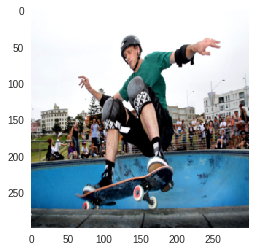

In [21]:
#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/skate.jpg
img1 = plt.imread('data/skate.jpg')
img1 = imresize(img1, (299, 299)).astype('float32') / 255.
plt.rcParams["axes.grid"] = False
plt.imshow(img1)
plt.show()

In [23]:
for i in range(10):
    print(' '.join(generate_caption(img1, t=5.)[1:-1]))

a man riding a skateboard down a ramp .
a man on a skateboard on a skateboard .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard down a rail .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard on a skate board .
a man riding a skateboard down a rail .
a man riding a skateboard down a ramp .


--2018-11-13 11:19:22--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 23.185.0.2, 2620:12a:8001::2, 2620:12a:8000::2
Connecting to ccanimalclinic.com (ccanimalclinic.com)|23.185.0.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/cat_dog.jpg’

data/cat_dog.jpg    100%[===================>] 104.37K  --.-KB/s    in 0.08s   

2018-11-13 11:19:22 (1.36 MB/s) - ‘data/cat_dog.jpg’ saved [106870/106870]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


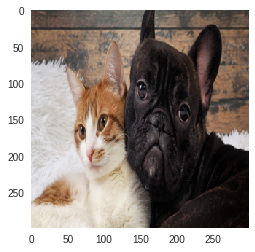

a cat is sitting on the floor with a dog .
a cat sitting on a bench with a dog .
a cat is laying on a bed with a toy .
a cat is sitting on a bench .
a cat is sitting on a couch .
a cat is laying on a bed with a dog in the background .
a cat standing next to a car with a dog .
a cat is sitting on a wooden bench .
a cat is sitting on a couch .
a cat is sitting on a wooden bench .


In [24]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/cat_dog.jpg
img = plt.imread('data/cat_dog.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

In [25]:
opt = torch.optim.Adam(network.parameters(), lr = 0.00005)
train(network, opt, 100, 100, n_validation_batches, device)

  4%|▍         | 4/100 [00:00<00:02, 39.28it/s]


Epoch: 0, train loss: 1.569546086192131, val loss: 1.8020968437194824


  5%|▌         | 5/100 [00:00<00:02, 41.79it/s]


Epoch: 1, train loss: 1.5856906706094742, val loss: 1.5815942764282227


  4%|▍         | 4/100 [00:00<00:02, 37.14it/s]


Epoch: 2, train loss: 1.5704944103956222, val loss: 1.4903478980064393


  4%|▍         | 4/100 [00:00<00:02, 39.28it/s]


Epoch: 3, train loss: 1.535282131433487, val loss: 1.4251136302947998


  4%|▍         | 4/100 [00:00<00:02, 36.66it/s]


Epoch: 4, train loss: 1.5280947798490525, val loss: 1.6555328130722047


  4%|▍         | 4/100 [00:00<00:02, 39.55it/s]


Epoch: 5, train loss: 1.4964768916368485, val loss: 1.6109080553054809


  4%|▍         | 4/100 [00:00<00:02, 35.15it/s]


Epoch: 6, train loss: 1.5176050359010695, val loss: 1.573076033592224


  5%|▌         | 5/100 [00:00<00:02, 35.63it/s]


Epoch: 7, train loss: 1.562401641011238, val loss: 1.600538158416748


  4%|▍         | 4/100 [00:00<00:02, 39.45it/s]


Epoch: 8, train loss: 1.5444457364082336, val loss: 1.5227249383926391


  4%|▍         | 4/100 [00:00<00:02, 36.92it/s]


Epoch: 9, train loss: 1.5525979870557785, val loss: 1.45121830701828


  4%|▍         | 4/100 [00:00<00:02, 36.99it/s]


Epoch: 10, train loss: 1.5388730096817016, val loss: 1.6342042446136475


  5%|▌         | 5/100 [00:00<00:02, 40.13it/s]


Epoch: 11, train loss: 1.5512723231315613, val loss: 1.4789138555526733


  4%|▍         | 4/100 [00:00<00:02, 39.11it/s]


Epoch: 12, train loss: 1.5424013888835908, val loss: 1.7505260944366454


  5%|▌         | 5/100 [00:00<00:02, 42.61it/s]


Epoch: 13, train loss: 1.5407461750507354, val loss: 1.6794760465621947


  4%|▍         | 4/100 [00:00<00:02, 37.63it/s]


Epoch: 14, train loss: 1.5649176579713822, val loss: 1.6182129383087158


  5%|▌         | 5/100 [00:00<00:02, 42.11it/s]


Epoch: 15, train loss: 1.5812278181314467, val loss: 1.7131203174591065


  4%|▍         | 4/100 [00:00<00:02, 38.79it/s]


Epoch: 16, train loss: 1.5304192340373992, val loss: 1.6445626020431519


  4%|▍         | 4/100 [00:00<00:02, 39.76it/s]


Epoch: 17, train loss: 1.601130295395851, val loss: 1.620076560974121


  5%|▌         | 5/100 [00:00<00:02, 41.35it/s]


Epoch: 18, train loss: 1.5531063508987426, val loss: 1.54433274269104


  5%|▌         | 5/100 [00:00<00:02, 41.43it/s]


Epoch: 19, train loss: 1.5319137650728225, val loss: 1.6144195795059204


  5%|▌         | 5/100 [00:00<00:02, 41.15it/s]


Epoch: 20, train loss: 1.5312911504507065, val loss: 1.7260812520980835


  5%|▌         | 5/100 [00:00<00:02, 41.06it/s]


Epoch: 21, train loss: 1.5490326547622681, val loss: 1.4928649187088012


  5%|▌         | 5/100 [00:00<00:02, 40.97it/s]


Epoch: 22, train loss: 1.5651934909820557, val loss: 1.5656005620956421


  5%|▌         | 5/100 [00:00<00:02, 42.29it/s]


Epoch: 23, train loss: 1.5513321924209595, val loss: 1.6512482166290283


  5%|▌         | 5/100 [00:00<00:02, 39.59it/s]


Epoch: 24, train loss: 1.5296345692873001, val loss: 1.5821909189224244


  5%|▌         | 5/100 [00:00<00:02, 41.31it/s]


Epoch: 25, train loss: 1.540019717812538, val loss: 1.6026572704315185


  4%|▍         | 4/100 [00:00<00:02, 36.06it/s]


Epoch: 26, train loss: 1.5283387124538421, val loss: 1.7284407138824462


  5%|▌         | 5/100 [00:00<00:02, 40.74it/s]


Epoch: 27, train loss: 1.5476932030916215, val loss: 1.526364803314209


  5%|▌         | 5/100 [00:00<00:02, 39.37it/s]


Epoch: 28, train loss: 1.527046599984169, val loss: 1.2987228035926819


  5%|▌         | 5/100 [00:00<00:02, 44.58it/s]


Epoch: 29, train loss: 1.520633693933487, val loss: 1.2887172460556031


  5%|▌         | 5/100 [00:00<00:02, 39.86it/s]


Epoch: 30, train loss: 1.5504715758562089, val loss: 1.5668861389160156


  4%|▍         | 4/100 [00:00<00:02, 37.28it/s]


Epoch: 31, train loss: 1.5002238583564758, val loss: 1.5604048252105713


  4%|▍         | 4/100 [00:00<00:02, 39.00it/s]


Epoch: 32, train loss: 1.4855660730600357, val loss: 1.6191447734832765


  4%|▍         | 4/100 [00:00<00:02, 38.93it/s]


Epoch: 33, train loss: 1.4957763332128524, val loss: 1.5774370908737183


  4%|▍         | 4/100 [00:00<00:02, 33.91it/s]


Epoch: 34, train loss: 1.5490152388811111, val loss: 1.4776061296463012


  5%|▌         | 5/100 [00:00<00:02, 40.04it/s]


Epoch: 35, train loss: 1.5559393084049224, val loss: 1.3016080737113953


  4%|▍         | 4/100 [00:00<00:02, 36.11it/s]


Epoch: 36, train loss: 1.5725941896438598, val loss: 1.5728513956069947


  4%|▍         | 4/100 [00:00<00:02, 36.94it/s]


Epoch: 37, train loss: 1.4744651627540588, val loss: 1.4369823455810546


  4%|▍         | 4/100 [00:00<00:02, 39.78it/s]


Epoch: 38, train loss: 1.5058958965539933, val loss: 1.596466851234436


  5%|▌         | 5/100 [00:00<00:02, 41.72it/s]


Epoch: 39, train loss: 1.5487856155633926, val loss: 1.4196364998817443


  4%|▍         | 4/100 [00:00<00:02, 39.55it/s]


Epoch: 40, train loss: 1.5539231777191163, val loss: 1.7537712574005127


  5%|▌         | 5/100 [00:00<00:02, 43.03it/s]


Epoch: 41, train loss: 1.5934700167179108, val loss: 1.7971400976181031


  4%|▍         | 4/100 [00:00<00:02, 38.10it/s]


Epoch: 42, train loss: 1.5381573277711869, val loss: 1.6360259532928467


  5%|▌         | 5/100 [00:00<00:02, 41.01it/s]


Epoch: 43, train loss: 1.5184712743759154, val loss: 1.6652278900146484


  4%|▍         | 4/100 [00:00<00:02, 34.13it/s]


Epoch: 44, train loss: 1.53203338265419, val loss: 1.672684097290039


  4%|▍         | 4/100 [00:00<00:02, 38.26it/s]


Epoch: 45, train loss: 1.5195264166593552, val loss: 1.5569915056228638


  5%|▌         | 5/100 [00:00<00:02, 41.68it/s]


Epoch: 46, train loss: 1.4943810319900512, val loss: 1.4919397354125976


  4%|▍         | 4/100 [00:00<00:02, 38.91it/s]


Epoch: 47, train loss: 1.5592281687259675, val loss: 1.4049863338470459


  5%|▌         | 5/100 [00:00<00:02, 40.84it/s]


Epoch: 48, train loss: 1.5120865935087204, val loss: 1.5961475372314453


  5%|▌         | 5/100 [00:00<00:02, 39.95it/s]


Epoch: 49, train loss: 1.5380422389507293, val loss: 1.4222836136817931


  4%|▍         | 4/100 [00:00<00:02, 39.33it/s]


Epoch: 50, train loss: 1.5197193586826325, val loss: 1.550719428062439


  4%|▍         | 4/100 [00:00<00:02, 37.85it/s]


Epoch: 51, train loss: 1.5555392634868621, val loss: 1.4975593566894532


  4%|▍         | 4/100 [00:00<00:02, 35.42it/s]


Epoch: 52, train loss: 1.529426730275154, val loss: 1.2614417552947998


  4%|▍         | 4/100 [00:00<00:02, 36.10it/s]


Epoch: 53, train loss: 1.5312084919214248, val loss: 1.2935975313186645


  4%|▍         | 4/100 [00:00<00:02, 35.52it/s]


Epoch: 54, train loss: 1.5043502253293992, val loss: 1.2607718110084534


  4%|▍         | 4/100 [00:00<00:02, 39.99it/s]


Epoch: 55, train loss: 1.5294651645421982, val loss: 1.5807728052139283


  4%|▍         | 4/100 [00:00<00:02, 39.99it/s]


Epoch: 56, train loss: 1.4789106768369675, val loss: 1.4552283763885498


  4%|▍         | 4/100 [00:00<00:02, 33.11it/s]


Epoch: 57, train loss: 1.5184267818927766, val loss: 1.4482981204986571


  4%|▍         | 4/100 [00:00<00:02, 38.55it/s]


Epoch: 58, train loss: 1.5032607841491699, val loss: 1.6338396072387695


  5%|▌         | 5/100 [00:00<00:02, 40.15it/s]


Epoch: 59, train loss: 1.5627673584222794, val loss: 1.59888014793396


  5%|▌         | 5/100 [00:00<00:02, 42.05it/s]


Epoch: 60, train loss: 1.5237061595916748, val loss: 1.494351053237915


  4%|▍         | 4/100 [00:00<00:02, 38.74it/s]


Epoch: 61, train loss: 1.5232594573497773, val loss: 1.7034639835357666


  5%|▌         | 5/100 [00:00<00:02, 39.40it/s]


Epoch: 62, train loss: 1.48264639377594, val loss: 1.5342734098434447


  4%|▍         | 4/100 [00:00<00:02, 38.44it/s]


Epoch: 63, train loss: 1.4861341136693955, val loss: 1.6214109659194946


  4%|▍         | 4/100 [00:00<00:02, 33.83it/s]


Epoch: 64, train loss: 1.56432038128376, val loss: 1.3295349597930908


  4%|▍         | 4/100 [00:00<00:02, 39.41it/s]


Epoch: 65, train loss: 1.4840856206417083, val loss: 1.6338493347167968


  5%|▌         | 5/100 [00:00<00:02, 41.96it/s]


Epoch: 66, train loss: 1.5280830693244933, val loss: 1.698418664932251


  4%|▍         | 4/100 [00:00<00:02, 39.48it/s]


Epoch: 67, train loss: 1.5634597289562224, val loss: 1.366654109954834


  5%|▌         | 5/100 [00:00<00:02, 40.79it/s]


Epoch: 68, train loss: 1.5179649287462234, val loss: 1.8229746103286744


  5%|▌         | 5/100 [00:00<00:02, 39.50it/s]


Epoch: 69, train loss: 1.5659636455774306, val loss: 1.6829886436462402


  5%|▌         | 5/100 [00:00<00:02, 42.86it/s]


Epoch: 70, train loss: 1.517013435959816, val loss: 1.46211678981781


  4%|▍         | 4/100 [00:00<00:02, 36.45it/s]


Epoch: 71, train loss: 1.558489670753479, val loss: 1.6763334274291992


  5%|▌         | 5/100 [00:00<00:02, 41.99it/s]


Epoch: 72, train loss: 1.5027221137285232, val loss: 1.5799649000167846


  5%|▌         | 5/100 [00:00<00:02, 41.33it/s]


Epoch: 73, train loss: 1.5616571998596191, val loss: 1.3840835690498352


  5%|▌         | 5/100 [00:00<00:02, 41.73it/s]


Epoch: 74, train loss: 1.566030460000038, val loss: 1.5415271997451783


  5%|▌         | 5/100 [00:00<00:02, 40.85it/s]


Epoch: 75, train loss: 1.510978040099144, val loss: 1.4458153247833252


  5%|▌         | 5/100 [00:00<00:02, 39.77it/s]


Epoch: 76, train loss: 1.50843137383461, val loss: 1.5871454238891602


  4%|▍         | 4/100 [00:00<00:02, 37.63it/s]


Epoch: 77, train loss: 1.5314326727390288, val loss: 1.6464035511016846


  4%|▍         | 4/100 [00:00<00:02, 36.75it/s]


Epoch: 78, train loss: 1.5267103815078735, val loss: 1.5831397771835327


  5%|▌         | 5/100 [00:00<00:02, 42.02it/s]


Epoch: 79, train loss: 1.4908550029993057, val loss: 1.5561627388000487


  4%|▍         | 4/100 [00:00<00:02, 39.83it/s]


Epoch: 80, train loss: 1.4935290998220443, val loss: 1.5667980670928956


  4%|▍         | 4/100 [00:00<00:02, 39.15it/s]


Epoch: 81, train loss: 1.5010301226377487, val loss: 1.5240508794784546


  4%|▍         | 4/100 [00:00<00:02, 37.80it/s]


Epoch: 82, train loss: 1.5329849326610565, val loss: 1.526178002357483


  4%|▍         | 4/100 [00:00<00:02, 38.68it/s]


Epoch: 83, train loss: 1.5322106474637984, val loss: 1.5428187370300293


  4%|▍         | 4/100 [00:00<00:02, 34.41it/s]


Epoch: 84, train loss: 1.5364262092113494, val loss: 1.5996700286865235


  5%|▌         | 5/100 [00:00<00:02, 39.79it/s]


Epoch: 85, train loss: 1.4922514599561691, val loss: 1.7165974378585815


  4%|▍         | 4/100 [00:00<00:02, 39.60it/s]


Epoch: 86, train loss: 1.5064867252111436, val loss: 1.4817466735839844


  5%|▌         | 5/100 [00:00<00:02, 37.59it/s]


Epoch: 87, train loss: 1.5024639958143233, val loss: 1.5960494995117187


  4%|▍         | 4/100 [00:00<00:02, 39.51it/s]


Epoch: 88, train loss: 1.5428863286972045, val loss: 1.6478031635284425


  5%|▌         | 5/100 [00:00<00:02, 40.10it/s]


Epoch: 89, train loss: 1.5402411395311355, val loss: 1.532602310180664


  5%|▌         | 5/100 [00:00<00:02, 41.90it/s]


Epoch: 90, train loss: 1.4717238450050354, val loss: 1.6798806667327881


  4%|▍         | 4/100 [00:00<00:02, 32.60it/s]


Epoch: 91, train loss: 1.5336371839046479, val loss: 1.681666612625122


  4%|▍         | 4/100 [00:00<00:02, 39.07it/s]


Epoch: 92, train loss: 1.5072547352313996, val loss: 1.4621613502502442


  4%|▍         | 4/100 [00:00<00:02, 39.12it/s]


Epoch: 93, train loss: 1.468779324889183, val loss: 1.640841269493103


  4%|▍         | 4/100 [00:00<00:02, 39.31it/s]


Epoch: 94, train loss: 1.5392727053165436, val loss: 1.548063611984253


  5%|▌         | 5/100 [00:00<00:02, 39.98it/s]


Epoch: 95, train loss: 1.474347509741783, val loss: 1.630336380004883


  4%|▍         | 4/100 [00:00<00:02, 39.63it/s]


Epoch: 96, train loss: 1.522448569536209, val loss: 1.3429423570632935


  5%|▌         | 5/100 [00:00<00:02, 43.34it/s]


Epoch: 97, train loss: 1.5559603470563887, val loss: 1.4611283779144286


  5%|▌         | 5/100 [00:00<00:02, 41.67it/s]


Epoch: 98, train loss: 1.52390196621418, val loss: 1.4867833614349366


100%|██████████| 100/100 [00:02<00:00, 38.06it/s]


Epoch: 99, train loss: 1.4951600009202957, val loss: 1.3831865549087525
Finished!


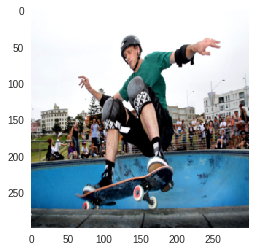

a man riding a skateboard on a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard down the side of a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .


In [26]:
plt.imshow(img1)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img1, t=5.)[1:-1]))

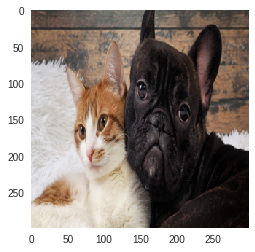

a cat is sitting on a couch with a cat .
a cat is sitting on a chair in a room .
a cat is sitting on a couch with a cat .
a cat is sitting on a couch with a cat on it .
a cat is sitting on a chair with a cat .
a cat sitting on a wooden floor next to a window .
a cat sitting on a chair with a cat .
a cat is laying down on a bed .
a cat sitting on a chair with a dog .
a cat is sitting on a chair with a dog .


In [27]:
plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Performance on the second picture became even worse

# Demo
### Find at least 10 images to test it on.
* Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
* Make sure it works okay on __simple__ images before going to something more comples
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime
* Mind the aspect ratio

In [0]:
links = ["https://bloximages.newyork1.vip.townnews.com/tulsaworld.com/content/tncms/assets/v3/editorial/d/c6/dc67e026-81c7-5bee-b1ca-79aaa944959b/53e7845e8e956.image.jpg", 
         "https://static1.squarespace.com/static/58fa000f8419c2eae4e942b2/t/5ad7bfc0562fa75adb8ec83e/1524088818484/Screen+Shot+2018-04-18+at+5.52.14+PM.png",  
         "https://www.everplans.com/sites/default/files/styles/article_header_image/public/girl-watering-plant-750.jpg", 
         "https://az760333.vo.msecnd.net/-/media/property/skamania-lodge/resort-overview/pet-friendly-skamania-pet-policies-crpd1440x600.jpg", 
         "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a4/Moscow_traffic_congestion.JPG/1200px-Moscow_traffic_congestion.JPG", 
         "http://justsomething.co/wp-content/uploads/2014/05/funny-animals-7.jpg", 
         "https://cdn.cambridge.co.nz/wp-content/uploads/2017/05/28210328/things-to-do-cambridge-farmers-market-1.jpg",
         "https://cdn-02.independent.ie/incoming/article29187755.ece/09276/AUTOCROP/w620/office2.png",
         "http://192.163.240.212/~careerk8/wp-content/uploads/2014/01/unhappy-at-work-1.jpg",
         "http://bpsa.org/cms/wp-content/uploads/E_Bike_17_Raleigh.jpg",
         "https://media-cdn.tripadvisor.com/media/photo-s/0f/cb/90/dd/family-friendly-camping.jpg",
         "https://img.grouponcdn.com/deal/aGHt4Zk9X7bGjGyVayJZAW/swan-boat-700x420/v1/c700x420.jpg",
         "https://d-pt.ppstatic.pl/k/r/1/6d/3a/5962a671b61c9_p.jpg?1499813180"]

In [28]:
!pip install wget
import wget

  Running setup.py bdist_wheel for wget ... - done
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
filenames = []
for url in links:
  filenames.append(wget.download(url, out="data/"))

In [33]:
images = []
for name in filenames:
  image = plt.imread(name)
  images.append(imresize(image, (299, 299)).astype('float32') / 255.)
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


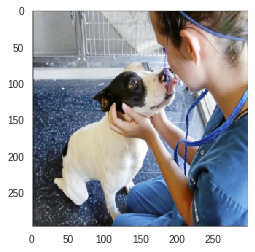

a man is holding a dog with a dog .
a man in a hat and a dog on a leash
a man is sitting on a bench with a dog .
a man and a dog are standing by a fire hydrant .
a man holding a dog and a dog in a car
a man is holding a dog in his mouth .
a man is holding a dog with a dog on his head .
a man is holding a dog with a dog in his mouth .
a man is holding a dog in a boat
a man is standing on a bench with a dog in the back .


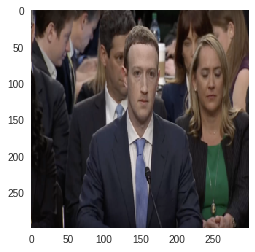

a group of men standing in a field .
a group of people standing around a table .
a group of people standing around a table .
a man and a woman are standing in a field .
a group of people standing in a field .
a group of people standing around a table .
a group of people standing around a table .
a group of people standing in a kitchen .
a group of people standing around a table
a group of people standing around a table


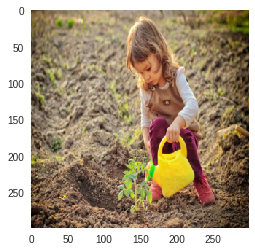

a young boy wearing a hat and a hat .
a woman in a red shirt is holding a surfboard .
a woman in a blue shirt holding a pink umbrella .
a woman in a red shirt and a hat
a young boy is holding a frisbee in his mouth .
a young girl is holding a frisbee in her mouth .
a woman is holding a frisbee in her mouth .
a young boy is holding a frisbee in his mouth .
a woman standing next to a child holding a surfboard .
a woman is holding a frisbee in her mouth .


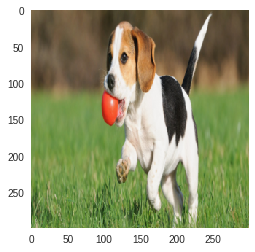

a large brown and white dog laying on a grass field .
a close up of a dog on a field .
a brown and white dog is laying on a field .
a brown and white dog laying on top of a field .
a brown and white dog laying on a grass covered field .
a large brown and white dog is laying on a field .
a small dog is laying on a grass field .
a white and black dog laying on top of a grass field .
a close up of a bird on a tree branch
a large brown bear is sitting on a wooden bench .


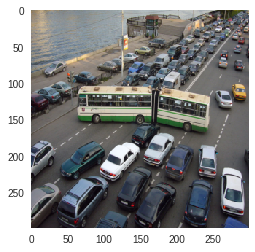

a bus is parked in front of a building .
a bus is parked in a parking lot with people .
a bus is parked in front of a bus stop .
a bus is parked on the street next to a bus .
a bus is parked in front of a building .
a bus is parked on the street near a building .
a bus is parked on the street with a car in the background .
a bus is parked in a parking lot .
a bus is parked on the street with a bus on it .
a bus is parked next to a parking lot .


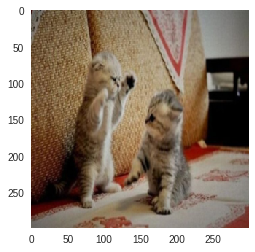

a cat laying on top of a bed with a laptop on it .
a cat is sitting on a couch with a cat .
a cat that is laying down on a couch .
a cat is laying on a bed with a cat .
a cat is sitting on a couch with a dog .
a cat laying on a bed with a laptop .
a cat is laying on a bed with a cat .
a cat is laying on a bed with a laptop .
a cat is sitting on a couch with a cat .
a cat is laying down on a bed .


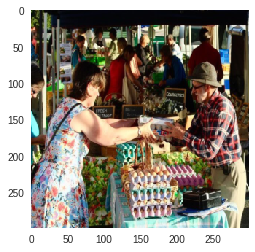

a man and woman are standing in front of a table .
a group of people standing around a table with a bunch of bananas .
a man in a red shirt and a woman holding a cake .
a man and woman are standing in a kitchen .
a woman and a woman standing in front of a table .
a man is standing in front of a store filled with food .
a man and woman are standing in a kitchen .
a man and a woman are standing in front of a table .
a group of people sitting around a table with a cake .
a group of people sitting at a table eating food .


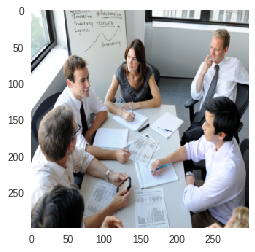

a group of people sitting at a table with a cake .
a group of people sitting at a table with a cake .
a group of people sitting at a table with a cake .
a group of people sitting at a table with a cake .
a group of people sitting at a table with a cake .
a group of people standing around a table .
a group of people sitting at a table with a cake .
a group of people sitting around a table with a cake .
a group of people sitting at a table with a cake .
a group of people sitting at a table with a laptop .


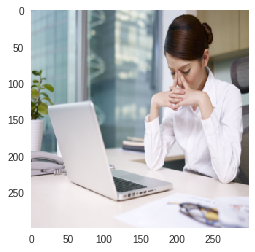

a man in a suit and tie is sitting on a table .
a man in a suit and a black shirt and a tie .
a man sitting at a table with a laptop computer .
a man is sitting at a table with a laptop computer .
a man with a beard and a woman sitting in front of a laptop .
a man is sitting at a table with a laptop computer .
a man sitting at a table with a laptop computer .
a man is sitting at a table with a laptop on it .
a man in a suit and a tie with a laptop
a man sitting at a table with a laptop and a laptop on it .


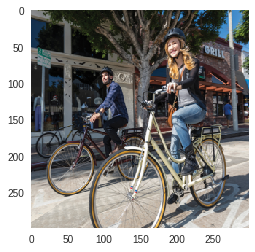

a man riding a skateboard down a street .
a man riding a skateboard down a street .
a man riding a bike down a street .
a man riding a bike on a street corner .
a man riding a motorcycle down a street .
a man is riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .


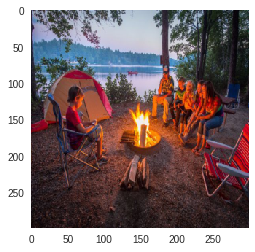

a group of people sitting on a bench .
a group of people sitting on a bench .
a group of people sitting on a bench in a park .
a group of people sitting on a bench next to a lake .
a group of people standing around a bench .
a couple of people sitting on a bench .
a group of people sitting on a bench .
a group of people standing on a bench
a group of people standing on a bench .
a group of people sitting on a bench .


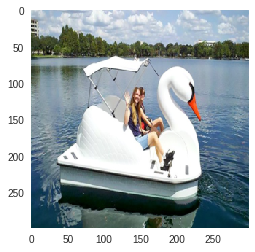

a man is sitting on a boat in the water .
a man is riding a boat in the water .
a white and white boat sitting in the water .
a man is sitting on a boat in the water .
a man is sitting on a boat in the water
a man is sitting on a boat in the water .
a man is sitting on a boat in the water .
a man is sitting on a boat in the water .
a white boat sitting on a boat in the water .
a man is riding a boat on a lake .


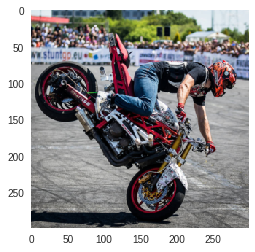

a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a road .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .


In [34]:
for img in images:
  plt.imshow(img)
  plt.show()
  for i in range(10):
      print(' '.join(generate_caption(img, t=5.)[1:-1]))
  

The network is still insane:


*   "a man is holding a dog with a dog in his mouth."
*   "a woman is holding a frisbee in her mouth ." (I think the network doesn't even know about the existence of watering can)
* "a group of people sitting at a table with a cake ." **$\times$ 7** (It definitely likes cakes despite the fact that there is no cakes in the picture)
* The network refuses to admit that this is a woman in some pictures.

Let's train more



In [0]:
model_state = network.state_dict()

In [36]:
opt = torch.optim.Adam(network.parameters(), lr = 0.00005)
train(network, opt, 100, 100, n_validation_batches, device)

  5%|▌         | 5/100 [00:00<00:02, 39.15it/s]


Epoch: 0, train loss: 1.4899249964952468, val loss: 1.5320347785949706


  5%|▌         | 5/100 [00:00<00:02, 38.92it/s]


Epoch: 1, train loss: 1.4694275784492492, val loss: 1.6122319936752318


  5%|▌         | 5/100 [00:00<00:02, 40.30it/s]


Epoch: 2, train loss: 1.5557363688945771, val loss: 1.3263969540596008


  5%|▌         | 5/100 [00:00<00:02, 42.34it/s]


Epoch: 3, train loss: 1.5070345175266266, val loss: 1.528944230079651


  4%|▍         | 4/100 [00:00<00:02, 39.62it/s]


Epoch: 4, train loss: 1.5278542304039002, val loss: 1.6692412853240968


  4%|▍         | 4/100 [00:00<00:02, 39.00it/s]


Epoch: 5, train loss: 1.5186768138408662, val loss: 1.5215393543243407


  4%|▍         | 4/100 [00:00<00:02, 38.04it/s]


Epoch: 6, train loss: 1.4675920897722243, val loss: 1.495027232170105


  5%|▌         | 5/100 [00:00<00:02, 40.30it/s]


Epoch: 7, train loss: 1.4836510133743286, val loss: 1.6160948514938354


  4%|▍         | 4/100 [00:00<00:02, 38.79it/s]


Epoch: 8, train loss: 1.5478863281011581, val loss: 1.3933188438415527


  4%|▍         | 4/100 [00:00<00:02, 35.76it/s]


Epoch: 9, train loss: 1.4997761648893357, val loss: 1.743218731880188


  4%|▍         | 4/100 [00:00<00:02, 36.99it/s]


Epoch: 10, train loss: 1.4928681457042694, val loss: 1.4489894390106202


  4%|▍         | 4/100 [00:00<00:02, 37.04it/s]


Epoch: 11, train loss: 1.476608649492264, val loss: 1.5590713500976563


  4%|▍         | 4/100 [00:00<00:02, 38.85it/s]


Epoch: 12, train loss: 1.4848760420084, val loss: 1.4917998313903809


  5%|▌         | 5/100 [00:00<00:02, 41.92it/s]


Epoch: 13, train loss: 1.486541006565094, val loss: 1.3590373039245605


  5%|▌         | 5/100 [00:00<00:02, 42.63it/s]


Epoch: 14, train loss: 1.5410462981462478, val loss: 1.5213382959365844


  4%|▍         | 4/100 [00:00<00:02, 38.57it/s]


Epoch: 15, train loss: 1.5497956162691116, val loss: 1.471609401702881


  5%|▌         | 5/100 [00:00<00:02, 42.17it/s]


Epoch: 16, train loss: 1.5311023968458175, val loss: 1.5324065208435058


  4%|▍         | 4/100 [00:00<00:02, 38.27it/s]


Epoch: 17, train loss: 1.5469502657651901, val loss: 1.4508145332336426


  5%|▌         | 5/100 [00:00<00:02, 40.94it/s]


Epoch: 18, train loss: 1.473714394569397, val loss: 1.682870054244995


  4%|▍         | 4/100 [00:00<00:02, 39.79it/s]


Epoch: 19, train loss: 1.5080544257164001, val loss: 1.348923921585083


  5%|▌         | 5/100 [00:00<00:02, 42.52it/s]


Epoch: 20, train loss: 1.4177265971899033, val loss: 1.6144123792648315


  4%|▍         | 4/100 [00:00<00:02, 37.93it/s]


Epoch: 21, train loss: 1.492304446697235, val loss: 1.6550055027008057


  4%|▍         | 4/100 [00:00<00:02, 38.95it/s]


Epoch: 22, train loss: 1.489955261349678, val loss: 1.597410297393799


  5%|▌         | 5/100 [00:00<00:02, 42.95it/s]


Epoch: 23, train loss: 1.5440269309282302, val loss: 1.578074073791504


  4%|▍         | 4/100 [00:00<00:02, 39.05it/s]


Epoch: 24, train loss: 1.5409546029567718, val loss: 1.457110095024109


  5%|▌         | 5/100 [00:00<00:02, 41.19it/s]


Epoch: 25, train loss: 1.5555040156841278, val loss: 1.482325005531311


  4%|▍         | 4/100 [00:00<00:02, 37.01it/s]


Epoch: 26, train loss: 1.476266341805458, val loss: 1.3845221757888795


  5%|▌         | 5/100 [00:00<00:02, 40.45it/s]


Epoch: 27, train loss: 1.5133686435222626, val loss: 1.480002760887146


  4%|▍         | 4/100 [00:00<00:02, 37.24it/s]


Epoch: 28, train loss: 1.4992283993959428, val loss: 1.2950594186782838


  5%|▌         | 5/100 [00:00<00:02, 40.99it/s]


Epoch: 29, train loss: 1.5343382149934768, val loss: 1.6746670484542847


  4%|▍         | 4/100 [00:00<00:02, 38.75it/s]


Epoch: 30, train loss: 1.4799266505241393, val loss: 1.334842276573181


  4%|▍         | 4/100 [00:00<00:02, 39.98it/s]


Epoch: 31, train loss: 1.5096840822696687, val loss: 1.611899733543396


  5%|▌         | 5/100 [00:00<00:02, 39.78it/s]


Epoch: 32, train loss: 1.528459135890007, val loss: 1.6130911588668824


  5%|▌         | 5/100 [00:00<00:02, 41.96it/s]


Epoch: 33, train loss: 1.5305243295431137, val loss: 1.595630669593811


  4%|▍         | 4/100 [00:00<00:02, 37.87it/s]


Epoch: 34, train loss: 1.5351561558246614, val loss: 1.1212130546569825


  5%|▌         | 5/100 [00:00<00:02, 40.03it/s]


Epoch: 35, train loss: 1.5190594631433487, val loss: 1.4750995635986328


  5%|▌         | 5/100 [00:00<00:02, 41.31it/s]


Epoch: 36, train loss: 1.4958279412984847, val loss: 1.3681928277015687


  4%|▍         | 4/100 [00:00<00:02, 37.56it/s]


Epoch: 37, train loss: 1.5208062034845353, val loss: 1.624316191673279


  5%|▌         | 5/100 [00:00<00:02, 42.64it/s]


Epoch: 38, train loss: 1.5088446253538133, val loss: 1.5383078575134277


  5%|▌         | 5/100 [00:00<00:02, 40.46it/s]


Epoch: 39, train loss: 1.524139878153801, val loss: 1.7299455642700194


  4%|▍         | 4/100 [00:00<00:02, 38.68it/s]


Epoch: 40, train loss: 1.5104052102565766, val loss: 1.6267271280288695


  4%|▍         | 4/100 [00:00<00:02, 35.94it/s]


Epoch: 41, train loss: 1.5013090199232102, val loss: 1.4220564842224122


  4%|▍         | 4/100 [00:00<00:02, 39.60it/s]


Epoch: 42, train loss: 1.5105774188041687, val loss: 1.383371067047119


  5%|▌         | 5/100 [00:00<00:02, 40.64it/s]


Epoch: 43, train loss: 1.512262825369835, val loss: 1.4689872980117797


  4%|▍         | 4/100 [00:00<00:02, 37.37it/s]


Epoch: 44, train loss: 1.5054380738735198, val loss: 1.6094974279403687


  4%|▍         | 4/100 [00:00<00:02, 38.29it/s]


Epoch: 45, train loss: 1.5169329172372819, val loss: 1.4122247457504273


  4%|▍         | 4/100 [00:00<00:02, 32.38it/s]


Epoch: 46, train loss: 1.554781909584999, val loss: 1.6164432525634767


  4%|▍         | 4/100 [00:00<00:02, 38.95it/s]


Epoch: 47, train loss: 1.5409117478132248, val loss: 1.4097230672836303


  5%|▌         | 5/100 [00:00<00:02, 41.55it/s]


Epoch: 48, train loss: 1.5437659454345702, val loss: 1.6770452976226806


  3%|▎         | 3/100 [00:00<00:03, 27.98it/s]


Epoch: 49, train loss: 1.5289502096176149, val loss: 1.6482624053955077


  4%|▍         | 4/100 [00:00<00:02, 36.87it/s]


Epoch: 50, train loss: 1.5077539777755737, val loss: 1.6111060619354247


  5%|▌         | 5/100 [00:00<00:02, 41.74it/s]


Epoch: 51, train loss: 1.490363507270813, val loss: 1.4236255168914795


  4%|▍         | 4/100 [00:00<00:02, 39.74it/s]


Epoch: 52, train loss: 1.5322149646282197, val loss: 1.5665838718414307


  4%|▍         | 4/100 [00:00<00:02, 38.68it/s]


Epoch: 53, train loss: 1.4952077943086624, val loss: 1.3982585668563843


  5%|▌         | 5/100 [00:00<00:02, 41.87it/s]


Epoch: 54, train loss: 1.500060089826584, val loss: 1.70242018699646


  4%|▍         | 4/100 [00:00<00:02, 38.31it/s]


Epoch: 55, train loss: 1.5335473710298537, val loss: 1.4988807678222655


  5%|▌         | 5/100 [00:00<00:02, 41.99it/s]


Epoch: 56, train loss: 1.494028975367546, val loss: 1.3499248623847961


  4%|▍         | 4/100 [00:00<00:02, 35.84it/s]


Epoch: 57, train loss: 1.5183205676078797, val loss: 1.5804858684539795


  4%|▍         | 4/100 [00:00<00:02, 39.03it/s]


Epoch: 58, train loss: 1.5285405284166336, val loss: 1.500811266899109


  4%|▍         | 4/100 [00:00<00:02, 35.68it/s]


Epoch: 59, train loss: 1.5163532328605651, val loss: 1.2137630343437196


  5%|▌         | 5/100 [00:00<00:02, 42.29it/s]


Epoch: 60, train loss: 1.518322920203209, val loss: 1.5119316101074218


  5%|▌         | 5/100 [00:00<00:02, 43.06it/s]


Epoch: 61, train loss: 1.4810946470499038, val loss: 1.373921275138855


  4%|▍         | 4/100 [00:00<00:02, 38.88it/s]


Epoch: 62, train loss: 1.4836413317918777, val loss: 1.7338228702545166


  5%|▌         | 5/100 [00:00<00:02, 41.13it/s]


Epoch: 63, train loss: 1.4814153981208802, val loss: 1.6808001756668092


  4%|▍         | 4/100 [00:00<00:02, 39.18it/s]


Epoch: 64, train loss: 1.4125678324699402, val loss: 1.5953421115875244


  5%|▌         | 5/100 [00:00<00:02, 41.08it/s]


Epoch: 65, train loss: 1.509766816496849, val loss: 1.6854798793792725


  5%|▌         | 5/100 [00:00<00:02, 40.66it/s]


Epoch: 66, train loss: 1.5450042510032653, val loss: 1.4974555134773255


  5%|▌         | 5/100 [00:00<00:02, 40.85it/s]


Epoch: 67, train loss: 1.476316254734993, val loss: 1.3978266954421996


  4%|▍         | 4/100 [00:00<00:02, 39.05it/s]


Epoch: 68, train loss: 1.5324349653720857, val loss: 1.4176920890808105


  5%|▌         | 5/100 [00:00<00:02, 40.31it/s]


Epoch: 69, train loss: 1.4961160081624985, val loss: 1.5020472049713134


  3%|▎         | 3/100 [00:00<00:03, 29.69it/s]


Epoch: 70, train loss: 1.5252478533983231, val loss: 1.5033694982528687


  4%|▍         | 4/100 [00:00<00:02, 39.24it/s]


Epoch: 71, train loss: 1.4848590075969696, val loss: 1.4640929341316222


  5%|▌         | 5/100 [00:00<00:02, 41.63it/s]


Epoch: 72, train loss: 1.5089973354339599, val loss: 1.548149013519287


  5%|▌         | 5/100 [00:00<00:02, 41.39it/s]


Epoch: 73, train loss: 1.5079169869422913, val loss: 1.3132370114326477


  5%|▌         | 5/100 [00:00<00:02, 42.76it/s]


Epoch: 74, train loss: 1.5046135675907135, val loss: 1.6640332698822022


  4%|▍         | 4/100 [00:00<00:02, 36.93it/s]


Epoch: 75, train loss: 1.520955854654312, val loss: 1.5639482736587524


  5%|▌         | 5/100 [00:00<00:02, 41.57it/s]


Epoch: 76, train loss: 1.5196167314052582, val loss: 1.5491461277008056


  4%|▍         | 4/100 [00:00<00:02, 39.02it/s]


Epoch: 77, train loss: 1.5438250863552094, val loss: 1.4948574423789978


  4%|▍         | 4/100 [00:00<00:02, 38.14it/s]


Epoch: 78, train loss: 1.5135476297140122, val loss: 1.5667700171470642


  4%|▍         | 4/100 [00:00<00:02, 37.06it/s]


Epoch: 79, train loss: 1.4720522147417068, val loss: 1.4398480296134948


  5%|▌         | 5/100 [00:00<00:02, 41.87it/s]


Epoch: 80, train loss: 1.5375418132543563, val loss: 1.4513210296630858


  5%|▌         | 5/100 [00:00<00:02, 41.86it/s]


Epoch: 81, train loss: 1.501257289648056, val loss: 1.5608484268188476


  5%|▌         | 5/100 [00:00<00:02, 40.59it/s]


Epoch: 82, train loss: 1.511001499891281, val loss: 1.485516333580017


  3%|▎         | 3/100 [00:00<00:03, 29.25it/s]


Epoch: 83, train loss: 1.5438233286142349, val loss: 1.486731219291687


  4%|▍         | 4/100 [00:00<00:02, 36.47it/s]


Epoch: 84, train loss: 1.4720753812789917, val loss: 1.601138710975647


  4%|▍         | 4/100 [00:00<00:02, 38.74it/s]


Epoch: 85, train loss: 1.501318198442459, val loss: 1.6516610145568849


  5%|▌         | 5/100 [00:00<00:02, 41.82it/s]


Epoch: 86, train loss: 1.4726793992519378, val loss: 1.415541982650757


  5%|▌         | 5/100 [00:00<00:02, 41.91it/s]


Epoch: 87, train loss: 1.4960466492176057, val loss: 1.6976571083068848


  4%|▍         | 4/100 [00:00<00:02, 39.02it/s]


Epoch: 88, train loss: 1.5110036927461623, val loss: 1.5784713506698609


  4%|▍         | 4/100 [00:00<00:02, 39.80it/s]


Epoch: 89, train loss: 1.4880515372753143, val loss: 1.6596890211105346


  4%|▍         | 4/100 [00:00<00:02, 32.30it/s]


Epoch: 90, train loss: 1.5049325704574585, val loss: 1.39993017911911


  5%|▌         | 5/100 [00:00<00:02, 42.87it/s]


Epoch: 91, train loss: 1.491982717514038, val loss: 1.4959306955337524


  4%|▍         | 4/100 [00:00<00:02, 33.92it/s]


Epoch: 92, train loss: 1.4865236681699754, val loss: 1.5367709159851075


  4%|▍         | 4/100 [00:00<00:02, 39.73it/s]


Epoch: 93, train loss: 1.4690811812877655, val loss: 1.5009641170501709


  4%|▍         | 4/100 [00:00<00:02, 37.83it/s]


Epoch: 94, train loss: 1.4801000988483428, val loss: 1.7109465837478637


  4%|▍         | 4/100 [00:00<00:02, 38.08it/s]


Epoch: 95, train loss: 1.5034064555168152, val loss: 1.6100842475891113


  5%|▌         | 5/100 [00:00<00:02, 42.19it/s]


Epoch: 96, train loss: 1.4915044182538986, val loss: 1.4817455530166626


  4%|▍         | 4/100 [00:00<00:02, 38.79it/s]


Epoch: 97, train loss: 1.5030663841962815, val loss: 1.3749936103820801


  4%|▍         | 4/100 [00:00<00:02, 38.86it/s]


Epoch: 98, train loss: 1.504348337650299, val loss: 1.6008182406425475


100%|██████████| 100/100 [00:02<00:00, 38.72it/s]


Epoch: 99, train loss: 1.499078202843666, val loss: 1.533966851234436
Finished!


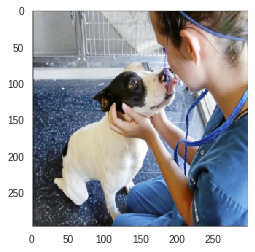

a man and a woman are walking down a street .
a man is holding a dog in his mouth .
a man in a hat and a dog holding a frisbee .
a man in a hat and a hat and a dog .
a man is holding a dog in his mouth .
a man is holding a dog in his mouth .
a man is holding a dog in his mouth .
a man is standing next to a dog .
a man is holding a dog with a dog on his head .
a man is holding a dog on a leash


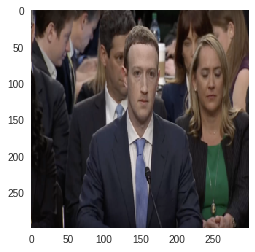

a group of people standing around a table .
a group of people standing around a table .
a man and a woman are posing for a picture .
a group of people standing in a room .
a group of people standing around a table with a cake .
a group of people standing around a table
a group of people standing in a kitchen .
a group of people standing around a table .
a group of people standing around a table .
a group of people standing around a table .


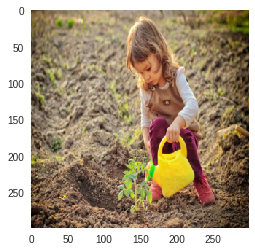

a woman is standing on a beach holding a frisbee .
a woman standing next to a child holding a frisbee .
a young girl is holding a frisbee in her mouth .
a woman with a child and a dog on her head .
a woman is holding a surfboard on the beach .
a woman is holding a surfboard on a beach .
a woman is holding a frisbee in her mouth .
a woman in a red shirt and a hat and a hat
a woman is holding a frisbee in her mouth .
a woman is holding a surfboard on a beach .


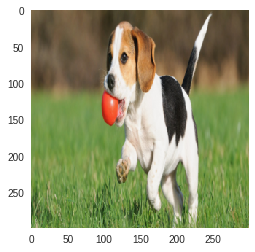

a large brown and white dog laying on a grass field .
a small dog is standing in a field .
a small dog is standing on a wooden bench .
a large brown and white dog laying on a grass field .
a small bird is sitting on a tree branch .
a close up of a bird that is on a tree
a brown and white dog standing next to a tree .
a close up of a dog in a field
a brown and white dog laying on top of a grass covered field .
a brown and white dog is standing in a field .


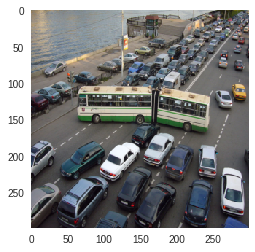

a bus is parked on the street in the street .
a bus is parked on the side of a street .
a bus is parked on the street next to a building .
a bus is parked in front of a building .
a bus is parked on the street with a bus on the side .
a bus is parked in front of a building .
a bus is parked in front of a building .
a bus is parked in front of a building .
a bus is parked on the street with a bus on the side .
a bus is parked on the street with a bus .


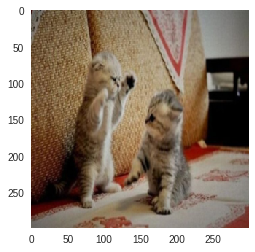

a cat is sitting on a bed with a cat .
a cat laying on top of a bed with a cat .
a cat laying on a bed with a remote control .
a cat laying on a couch with a cat .
a cat is laying on a bed with a cat .
a cat is sitting on a couch with a cat on his lap .
a cat sitting on a chair with a cat on it .
a cat is laying on a bed with a cat .
a cat laying on a couch with a remote control .
a cat is laying on a bed with a blanket .


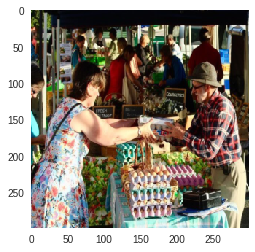

a man and woman are standing in a kitchen .
a group of people standing around a table with food .
a group of people standing around a table with food .
a group of people standing around a table with food .
a man and a woman are standing around a table .
a group of people sitting around a table .
a group of people standing around a table with food .
a group of people standing around a table with food .
a man and a woman are standing in front of a table .
a man and woman standing in front of a store .


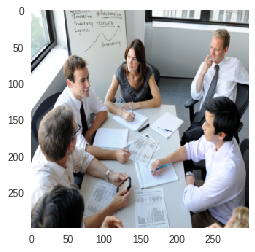

a group of people sitting at a table with a laptop
a group of people sitting at a table with a laptop .
a group of people sitting at a table with a laptop .
a group of people sitting at a table with a laptop .
a group of people sitting around a table .
a group of people sitting at a table with a laptop .
a group of people sitting at a table with a laptop .
a group of people sitting at a table with a laptop .
a group of people sitting at a table with a laptop .
a group of people sitting around a table with a cake .


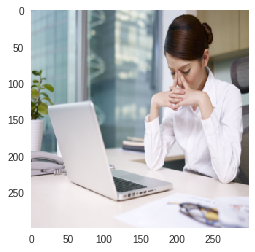

a man sitting at a table with a plate of food .
a man sitting at a table with a laptop and a laptop .
a man is sitting at a table with a laptop .
a man sitting at a table with a laptop computer .
a man sitting at a table with a laptop
a man sitting on a table with a laptop computer .
a man is sitting at a table with a laptop computer .
a man sitting at a table with a laptop computer .
a man in a suit and tie sitting at a table .
a man sitting at a table with a laptop .


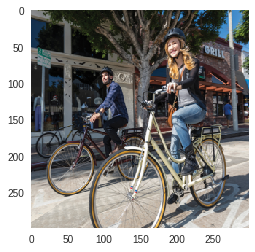

a man is sitting on a bench in a parking lot .
a man riding a skateboard down a street .
a man riding a bike down a street .
a man riding a bicycle on a city street .
a man riding a bike down a street .
a man on a motorcycle is riding a motorcycle .
a man riding a bike down a street .
a man riding a motorcycle down a street .
a man in a black jacket is standing on a motorcycle .
a man riding a motorcycle down a street .


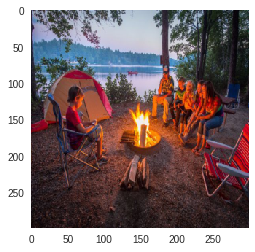

a group of people sitting on a bench .
a group of people sitting on a bench in the water .
a group of people standing on a bench in a park .
a group of people sitting on a bench .
a group of people standing around a bench .
a group of people sitting on a bench next to a beach .
a group of people sitting on a bench in front of a lake .
a group of people sitting on a bench .
a group of people standing on a bench
a group of people sitting on a bench .


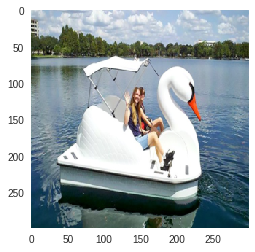

a man is riding a boat on a lake .
a boat is sitting on a boat in the water .
a man is sitting on a boat in the water .
a man is sitting on a boat in the water .
a man is riding a boat on a lake .
a white dog sitting on a boat in the water .
a man is sitting on a boat in the water .
a man is sitting on a boat in the water .
a man is standing in the water with a large boat in the water .
a man is riding a boat on a lake .


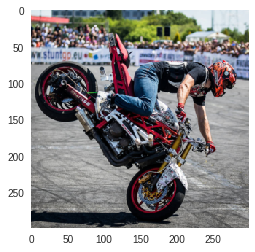

a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .


In [37]:
for img in images:
  plt.imshow(img)
  plt.show()
  for i in range(10):
      print(' '.join(generate_caption(img, t=5.)[1:-1]))

"a group of people sitting at a table with a laptop ."  $\times$ **8** now it likes laptops

In [43]:
opt = torch.optim.Adam(network.parameters(), lr = 0.00001)
train(network, opt, 10, 100, n_validation_batches, device)

  5%|▌         | 5/100 [00:00<00:02, 42.18it/s]


Epoch: 0, train loss: 1.5184573101997376, val loss: 1.5999541282653809


  4%|▍         | 4/100 [00:00<00:02, 38.38it/s]


Epoch: 1, train loss: 1.452131255865097, val loss: 1.7246719598770142


  5%|▌         | 5/100 [00:00<00:02, 43.94it/s]


Epoch: 2, train loss: 1.4588723784685136, val loss: 1.4930113315582276


  3%|▎         | 3/100 [00:00<00:03, 28.54it/s]


Epoch: 3, train loss: 1.4610919237136841, val loss: 1.4114344358444213


  4%|▍         | 4/100 [00:00<00:02, 32.89it/s]


Epoch: 4, train loss: 1.4794075667858124, val loss: 1.5281229496002198


  5%|▌         | 5/100 [00:00<00:02, 42.14it/s]


Epoch: 5, train loss: 1.416475191116333, val loss: 1.4950088500976562


  5%|▌         | 5/100 [00:00<00:02, 41.39it/s]


Epoch: 6, train loss: 1.4798366421461104, val loss: 1.350169062614441


  4%|▍         | 4/100 [00:00<00:02, 39.61it/s]


Epoch: 7, train loss: 1.4927194273471833, val loss: 1.6969924449920655


  5%|▌         | 5/100 [00:00<00:02, 41.56it/s]


Epoch: 8, train loss: 1.519227248430252, val loss: 1.4031899690628051


100%|██████████| 100/100 [00:02<00:00, 37.88it/s]



Epoch: 9, train loss: 1.4581140333414078, val loss: 1.5226861476898192
Finished!


**More or less good**

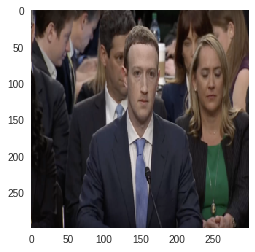

a group of people standing around a table .
a group of people standing in a room .
a group of people standing around a table .
a group of people standing around a table .
a group of people standing around a table .
a group of people standing around a table .
a group of people standing around a table .
a group of people standing around a table .
a group of people standing around a table .
a group of people standing around a table .


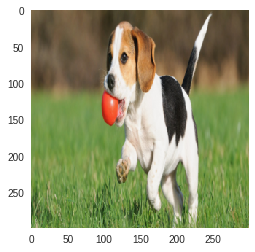

a brown and white dog laying on a grass covered field .
a brown and white dog is laying on a field .
a close up of a dog in a field
a small dog is standing on a grass field .
a dog is standing on a grass field .
a brown and white dog laying on a grass field .
a white and brown dog laying on top of a grass field .
a large white dog with a white frisbee in its mouth .
a close up of a dog on a leash
a small dog is standing on a dirt field .


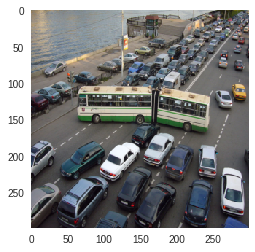

a bus is parked on the street next to a bus .
a bus is parked on the side of a street .
a bus is parked in front of a building .
a bus is parked on the street next to a bus .
a bus is parked in front of a building .
a bus is parked on the street with a bus on the side .
a bus is parked on the street next to a building .
a bus is parked on the street next to a bus .
a bus is parked on the street in the city .
a bus is parked on the street in the street .


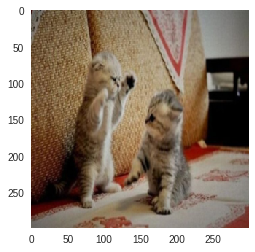

a cat laying on top of a bed with a cat .
a cat laying on a bed with a cat .
a cat sitting on a bed with a cat on it .
a cat laying on a bed with a cat .
a cat laying on a bed with a cat on the floor .
a cat is laying on a bed with a stuffed animal .
a cat is laying down on a bed .
a cat laying on a bed with a cat on it .
a cat laying on top of a blanket on a bed .
a cat laying on a bed with a cat on it


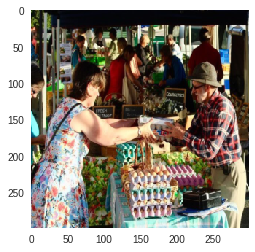

a group of people standing around a table with food .
a man and woman are standing in front of a table .
a group of people standing around a table with food .
a man and a woman are standing in front of a table .
a group of people standing around a table with a bunch of food .
a man and a woman are standing in front of a table .
a group of people standing around a table with food .
a man and woman standing next to a table filled with food .
a man and woman standing in front of a table .
a group of people are standing around a table .


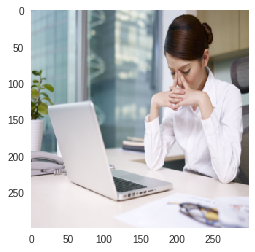

a man sitting at a table with a laptop and a laptop
a man sitting at a table with a laptop
a man sitting at a table with a laptop computer .
a man sitting at a table with a laptop computer .
a man sitting at a table with a laptop computer .
a man sitting at a table with a laptop computer .
a man is sitting at a table with a laptop .
a man is sitting at a table with a laptop computer .
a man sitting at a table with a laptop
a man sitting at a table with a laptop and a laptop


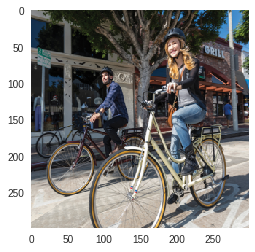

a man riding a bike down a street .
a man is sitting on a bench in the street .
a man in a red jacket is riding a bike .
a man in a suit is riding a bike .
a man riding a bike down a street .
a man riding a bike down a street .
a man is riding a skateboard on a street .
a man is riding a bike down the street .
a man riding a bike down a street .
a man riding a bike down a street .


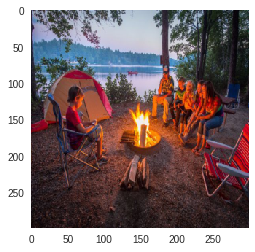

a group of people sitting on a bench .
a group of people sitting on a bench in the park .
a group of people sitting on a bench .
a group of people sitting on a bench in the park .
a group of people sitting on a bench in a park .
a group of people sitting on a bench .
a group of people sitting on a bench in the park .
a group of people sitting on a bench in the grass .
a group of people sitting on a bench .
a group of people sitting on a bench .


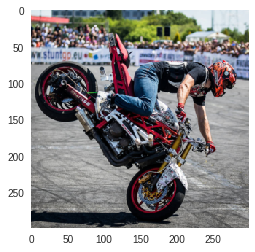

a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a road .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .


In [53]:
for i in [1,3,4,5,6,8,9,10,-1]:
  plt.imshow(images[i])
  plt.show()
  for j in range(10):
      print(' '.join(generate_caption(images[i], t=5.)[1:-1]))

But there are still mistakes: 
1) dog is running not standing or laying
2) "man" is actually a women

**Failures**

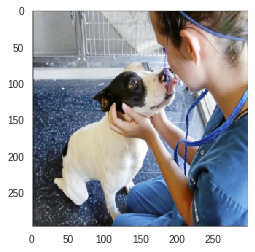

a man is holding a dog and a dog .
a man is holding a dog in his mouth .
a dog is standing in front of a fire hydrant .
a man and a woman are standing in the grass .
a man in a black shirt and a dog on a leash
a man is holding a dog in a dog .
a man with a hat and a dog on a leash
a man with a hat and a dog on a leash
a man is sitting on a bench with a dog .
a woman is sitting on a bench with a dog .


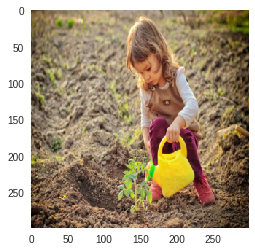

a young girl is holding a frisbee in her mouth .
a young girl sitting on a beach with a frisbee .
a young boy holding a frisbee in his mouth .
a young boy holding a frisbee in his mouth .
a woman in a blue shirt holding a frisbee .
a woman sitting on a beach with a frisbee .
a young boy holding a frisbee in his mouth .
a woman is holding a surfboard on a beach .
a woman is holding a baby on her head .
a woman standing next to a small child with a surfboard .


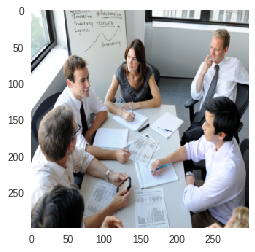

a group of people are playing a video game .
a group of people standing around a table with a cake .
a group of people are sitting at a table .
a group of people standing around a table .
a group of people standing around a table with a wii controller .
a group of people standing around a table with a cake .
a group of people standing around a table with a laptop .
a group of people sitting around a table with a laptop .
a group of people are sitting at a table .
a group of people sitting at a table with a laptop


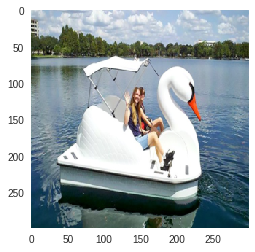

a white and white dog sitting on a boat in the water .
a man is riding a boat on a body of water .
a white and white boat sitting on a lake .
a white and white boat sitting on a lake .
a man sitting on a boat in the water .
a white boat sitting on a boat in the water .
a white and white boat sitting on a lake .
a white and white boat sitting on a lake .
a white and white boat sitting on a lake .
a man is sitting on a boat in the water .


In [56]:
for i in [0,2,7,-2]:
  plt.imshow(images[i])
  plt.show()
  for j in range(10):
      print(' '.join(generate_caption(images[i], t=5.)[1:-1]))


![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTnCz9JPzYRV2KbzKwxc4UU_Pl5xhrOcnyYUXrsDs5pUS1jTuOe)

### Now what?

Your model produces some captions but you still strive to improve it? You're damn right to do so. Here are some ideas that go beyond simply "stacking more layers". The options are listed easiest to hardest.

##### Attention
You can build better and more interpretable captioning model with attention.
* How it works: https://distill.pub/2016/augmented-rnns/
* One way of doing this in captioning: https://arxiv.org/abs/1502.03044
* You will have to create a dataset for attention with [this notebook](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

##### Subword level captioning
In the base version, we replace all rare words with UNKs which throws away a lot of information and reduces quality. A better way to deal with vocabulary size problem would be to use Byte-Pair Encoding

* BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory: https://arxiv.org/abs/1508.07909
* It was originally built for machine translation, but it should work with captioning just as well.

#### Reinforcement learning
* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week8](https://github.com/yandexdataschool/Practical_RL/tree/master/week8_scst)
* Theory: https://arxiv.org/abs/1612.00563